### Drawing arcs on Folium maps

**Objective:** connect two points on a map using an arc.

Because Folium doesn't have an arc drawing feature, here we try to generate kinds of *quasi*-arcs as sets of points to be connected by straight lines.

The [starting point](https://stackoverflow.com/questions/11331854/how-can-i-generate-an-arc-in-numpy/11332375#11332375) is an algorithm that, given a circumference center _(xc, yc)_, a radius R and an angle point in radians, returns the corresponding point _(x, y)_ on the circumference. The arc drawing algorithm just generates N points between two given angle points. There is also a function that does the inverse calculation, i.e., given the _(x, y)_ point, returns the angle: it is used at the start to determine the angles of the points being connected.

Problems found:

1. The limited domain _(0; π)_ of the `arccos` function. When converting between cartesian and angle points, the quadrant information is sometimes lost, e.g., a point on the 3rd quadrant will be recovered as being on the 2nd, because of the negative sign of the cosine. The same occurs between the 1st and 4th quadrants.
2. It solves just a part of the problem. Given points A and B to connect, it is needed to **find two circumference centers**, one for `A->B` and another for `B->A`.pink arcs on the plot) is something hard... The trick: when converting the cartesian points to angle points in a circumference, the coordinate system is translated to the choosen center and the `arctan2` NumPy function returns an angle point value that can be positive or negative, depending on the coordinate values of the point in the translated system.

Problem (1) was solved using [atan2](https://pt.wikipedia.org/wiki/Coordenadas_polares#Convers%C3%A3o_entre_coordenadas_polares_e_cartesianas) instead of `arccos`. Formulas for (2) can be found, but [this code sample](https://stackoverflow.com/questions/36211171/finding-arc-circle-center-given-2-points-and-radius) is already at hand. One can determine the two circumference centers passing the point parameters in different orders, _(A, B)_ or _(B, A)_.

The next challenge was to choose from all arc options: from each circumference, between points A and B, one can pick both clockwise and counter-clockwise arcs. All possible options are plotted with different colors at *Calculating arcs* section of this notebook.

To mathematically determine the desired arcs (green and pink arcs on the plot) is something hard... The trick: when converting the cartesian points to angle points in a circumference, the coordinate system is translated to the choosen center and the `arctan2` NumPy function returns an angle point value that can be positive or negative, depending on the coordinate values of the point in the translated system. The arc creation function takes advantage from that (with some magic, if somebody can clarify it...) using the `reverse` parameter to choose whether it accepts the value as it is or use always a positive equivalent angle value. This can distinguish the two possible possible arcs in that circumference!

Thus, the arrow drawing function creates two arcs, passing both `reverse=True` and `reverse=False` parameters, and chooses the one with the minimum angular length. The starting and ending angle points of the arcs are returned to favour the length measurement and hence the choice of the arc. What circumference center is used is determined by the order in which the points are passed, so that calling `draw_arrow(A, B)` uses one center and calling `draw_arrow(B, A)` uses another, making easy to plot bike flows.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import folium
import shapely.geometry as geom
from collections import namedtuple

###  Basic algorithm

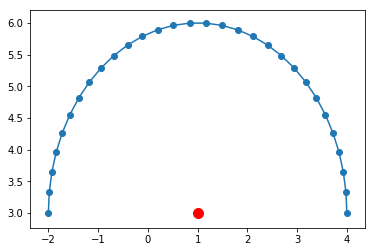

In [2]:
def parametric_circle_trivial(t, xc, yc, R):
    x = xc + R*np.cos(t)
    y = yc + R*np.sin(t)
    return x,y

def inv_parametric_circle_trivial(x, xc, R):
    t = np.arccos((x-xc)/R)
    return t

def create_arc_old(N, R, xc, yc, start_point, end_point):
    start_t = inv_parametric_circle_trivial(start_point[0], xc, R)
    end_t   = inv_parametric_circle_trivial(end_point[0], xc, R)
    arc_T = np.linspace(start_t, end_t, N)
    X, Y = parametric_circle_trivial(arc_T, xc, yc, R)
    return X, Y

N = 30
R = 3
xc = 1.0
yc = 3.0
start_point = parametric_circle_trivial(0.0, xc, yc, R)
end_point = parametric_circle_trivial(math.pi, xc, yc, R)
X, Y = create_arc_old(N, R, xc, yc, start_point, end_point)

plt.plot(X,Y)
plt.scatter(X,Y)
plt.scatter([xc],[yc],color='r',s=100)
plt.show()

### Finding circumference centers

In [3]:
def center_x(x1, y1, x2, y2, radius):
    radsq = radius * radius
    q = math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
    x3 = (x1 + x2) / 2
    return x3 + math.sqrt(radsq - ((q / 2) * (q / 2))) * ((y1 - y2) / q)

def center_y(x1, y1, x2, y2, radius):
    radsq = radius * radius
    q = math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))
    y3 = (y1 + y2) / 2
    return y3 + math.sqrt(radsq - ((q / 2) * (q / 2))) * ((x2-x1) / q)

In [4]:
assert abs(center_x(start_point[0], start_point[1], end_point[0], end_point[1], R) - xc) < 1e-8
assert abs(center_y(start_point[0], start_point[1], end_point[0], end_point[1], R) - yc) < 1e-8

### Using `arctan2` to convert between cartesian and angle points

**Problem!** Because of `arccos` or `arcsin` limited domains, it's not so trivial to transform a point into angle and vice versa.

Trying with polar coordinates:

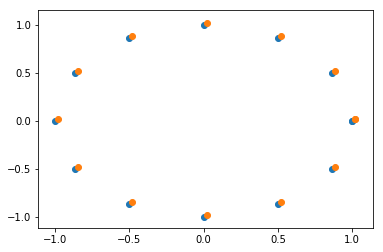

In [5]:
def inv_parametric_circle(x, y, xc, yc, R):
    translated_x = x - xc
    translated_y = y - yc
    return np.arctan2(translated_y, translated_x)

def parametric_circle(t, xc, yc, R):
    translated_x = R * np.cos(t)
    translated_y = R * np.sin(t)
    return translated_x + xc, translated_y + yc

R = 1
xc = 0
yc = 0

arc_T = np.linspace(0, 2*math.pi, 13)  # 0, pi/3, pi/6, pi, ...
x, y = parametric_circle_trivial(arc_T, xc, yc, R)
plt.scatter(x,y)

tests = inv_parametric_circle(x, y, xc, yc, R)
xt, yt = parametric_circle(tests, xc, yc, R)
plt.scatter(xt+.02, yt+.02)

plt.show()

In [6]:
def conference(x, y):
    the_zip = zip(x, y)
    ant = next(the_zip)
    for p in the_zip:
        if p == (1, 0): continue
        cx = center_x(ant[0], ant[1], p[0], p[1], R)
        cy = center_y(ant[0], ant[1], p[0], p[1], R)
        assert abs(cx) < 1e-8
        assert abs(cy) < 1e-8
        ant = p
    
conference(x, y)
conference(xt, yt)

### Calculating arcs

* *Blue* points: points being connected
* *Orange* points: circumference centers
* *Pink, darkred, green, lightblue*: arc options

1: -0.424635760613601 1.134237374344095
2: 1.134237374344095 5.858549546565985
3: -2.007355279245698 2.7169568929761923
4: 2.7169568929761923 4.275830027933888


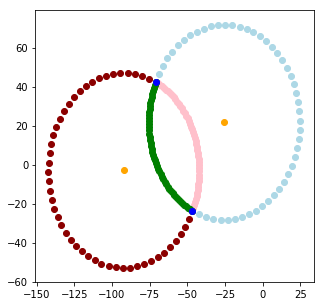

In [7]:
def create_arc(N, R, xc, yc, start_point, end_point, reverse=False):
    start_t = inv_parametric_circle(start_point[0], start_point[1], xc, yc, R)
    end_t = inv_parametric_circle(end_point[0], end_point[1], xc, yc, R)
    
    if reverse:
        start_t = (start_t + 2*math.pi) % (2*math.pi)
        end_t = (end_t + 2*math.pi) % (2*math.pi)
    
    arc_T = np.sort(np.linspace(start_t, end_t, N))
    X, Y = parametric_circle(arc_T, xc, yc, R)
    return X, Y, arc_T[0], arc_T[-1]

N = 50
RADIUS = 50

# (x, y)
map_center = [-66.397734, 15.752092]
sao_paulo = [-46.638823, -23.5489]
boston = [-71.057083, 42.361145]

xc1 = center_x(sao_paulo[0], sao_paulo[1], boston[0], boston[1], RADIUS)
yc1 = center_y(sao_paulo[0], sao_paulo[1], boston[0], boston[1], RADIUS)
xc2 = center_x(boston[0], boston[1], sao_paulo[0], sao_paulo[1], RADIUS)
yc2 = center_y(boston[0], boston[1], sao_paulo[0], sao_paulo[1], RADIUS)

plt.figure(figsize=(5, 5))
X1, Y1, start, end = create_arc(N, RADIUS, xc1, yc1, sao_paulo, boston)
print('1:', start, end)
X2, Y2, start, end = create_arc(N, RADIUS, xc1, yc1, sao_paulo, boston, reverse=True)
print('2:', start, end)
X3, Y3, start, end = create_arc(N, RADIUS, xc2, yc2, sao_paulo, boston)
print('3:', start, end)
X4, Y4, start, end = create_arc(N, RADIUS, xc2, yc2, sao_paulo, boston, reverse=True)
print('4:', start, end)

plt.scatter(X1, Y1, c='pink')
plt.scatter(X2, Y2, c='darkred')
plt.scatter(X3, Y3, c='lightblue')
plt.scatter(X4, Y4, c='green')

plt.scatter([sao_paulo[0]], [sao_paulo[1]], c='blue')
plt.scatter([boston[0]], [boston[1]], c='blue')
plt.scatter([xc1], [yc1], c='orange')
plt.scatter([xc2], [yc2], c='orange')

plt.show()

### Plotting arc arrows on Folium maps

In [8]:
def draw_arrow(folium_map, lat1, lon1, lat2, lon2, color='blue', weight=3, tip=6, text='', radius_fac=1.0):
    N = 30
    dist_x = lon1 - lon2
    dist_y = lat1 - lat2
    RADIUS = math.sqrt(dist_x*dist_x + dist_y*dist_y) * radius_fac
    
    xc = center_x(lon1, lat1, lon2, lat2, RADIUS)
    yc = center_y(lon1, lat1, lon2, lat2, RADIUS)
    arc_x, arc_y, start, end = create_arc(N, RADIUS, xc, yc, [lon1, lat1], [lon2, lat2], reverse=False)
    arc2_x, arc2_y, start2, end2 = create_arc(N, RADIUS, xc, yc, [lon1, lat1], [lon2, lat2], reverse=True)

    if (end2 - start2) < (end - start):
        arc_x, arc_y = arc2_x, arc2_y
        start, end = start2, end2

    arc_points = iter(zip(arc_y, arc_x))
    ant = next(arc_points)
    for p in arc_points:
        folium.PolyLine(locations=[ant, p], color=color, weight = weight, popup=text).add_to(folium_map)
        ant = p

    rotation = math.pi/2 - end + math.pi
    rotation *= 180 / math.pi  # use degrees
    folium.RegularPolygonMarker(location=[lat2, lon2], fill_color=color, number_of_sides=3, radius=tip, 
                            rotation=rotation, popup=text).add_to(folium_map)

# (y, x)
map_center = [15.752092, -66.397734]
sao_paulo = [-23.5489, -46.638823]
boston = [42.361145, -71.057083]

folium_map = folium.Map(map_center, zoom_start=3)

folium.Marker(location=sao_paulo, icon=folium.Icon(color='blue')).add_to(folium_map)
folium.Marker(location=boston, icon=folium.Icon(color='blue')).add_to(folium_map)

draw_arrow(folium_map, sao_paulo[0], sao_paulo[1], boston[0], boston[1])
draw_arrow(folium_map, boston[0], boston[1], sao_paulo[0], sao_paulo[1], color='red')

folium_map

Testing all directions, with different radius:

In [9]:
arc_T = np.linspace(0, 2*math.pi, 13)  # 0, pi/3, pi/6, pi, ...
x, y = parametric_circle_trivial(arc_T, map_center[1], map_center[0], 30)

folium_map = folium.Map(map_center, zoom_start=3)

for i in range(len(x)):
    draw_arrow(folium_map, map_center[0], map_center[1], y[i], x[i], radius_fac=1)
    draw_arrow(folium_map, y[i], x[i], map_center[0], map_center[1], radius_fac=3, color='red')
    
folium_map

Fully vertical arrow test:

In [10]:
# (y, x)
map_center = [0, 0]
A = [-20, 0]
B = [20, 0]

folium_map = folium.Map(map_center, zoom_start=3)

folium.Marker(location=A, icon=folium.Icon(color='blue')).add_to(folium_map)
folium.Marker(location=B, icon=folium.Icon(color='blue')).add_to(folium_map)

draw_arrow(folium_map, A[0], A[1], B[0], B[1])
draw_arrow(folium_map, B[0], B[1], A[0], A[1], color='red')

folium_map